In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

import matplotlib.pyplot as plt
from IPython.display import HTML

from tqdm import tqdm

%matplotlib inline
plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams['axes.titlesize'] = 16

In [3]:
#calendar.csv - Contains information about the dates on which the products are sold.
#sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
#sample_submission.csv - The correct format for submissions. Reference the Evaluation tab for more info.
#sell_prices.csv - Contains information about the price of the products sold per store and date.

In [4]:
cal = pd.read_csv('calendar.csv')
stv = pd.read_csv('sales_train_validation.csv')
ss = pd.read_csv('sample_submission.csv')
sellp = pd.read_csv('sell_prices.csv')

In [5]:
sellp.tail()

,store_id,item_id,wm_yr_wk,sell_price
6841116,WI_3,FOODS_3_827,11617,1.0
6841117,WI_3,FOODS_3_827,11618,1.0
6841118,WI_3,FOODS_3_827,11619,1.0
6841119,WI_3,FOODS_3_827,11620,1.0
6841120,WI_3,FOODS_3_827,11621,1.0


In [6]:
cal.shape

(1969, 14)

In [7]:
cal.head()
# d:data organized in this column, corresponding to train 
# event_name_1,event_type_1,event_name_2,event_type_2: if special events happen
# snap_Ca, snap_tx, snap_wi:snap provides low income family and individuals with extra benefits to purchase food, 
# usually 10 days per month

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [8]:
cal.tail()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0
1968,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


In [9]:
cal.dtypes

date            object
wm_yr_wk         int64
weekday         object
wday             int64
month            int64
year             int64
d               object
event_name_1    object
event_type_1    object
event_name_2    object
event_type_2    object
snap_CA          int64
snap_TX          int64
snap_WI          int64
dtype: object

In [10]:
#missing value
cal_na = (cal.isnull().sum() / len(cal)) * 100
cal_na = cal_na.drop(cal_na[cal_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :cal_na})
missing_data

,Missing Ratio
event_type_2,99.746064
event_name_2,99.746064
event_type_1,91.772473
event_name_1,91.772473


In [11]:
stv.shape

(30490, 1919)

In [12]:
stv.head()
#rows exist in this dataset for days d_1 to d_1913. 
#d_:unit sales, target
#We are given the department, category, state, and store id of the item.
#d_1914 - d_1941 represents the validation rows which we will predict in stage 1
#d_1942 - d_1969 represents the evaluation rows which we will predict for the final competition standings.

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [13]:
stv.dtypes

id          object
item_id     object
dept_id     object
cat_id      object
store_id    object
             ...  
d_1909       int64
d_1910       int64
d_1911       int64
d_1912       int64
d_1913       int64
Length: 1919, dtype: object

In [14]:
#missing value
stv_na = (stv.isnull().sum() / len(cal)) * 100
stv_na = stv_na.drop(stv_na[stv_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :stv_na})
missing_data # no missing value

,Missing Ratio


In [15]:
sellp.shape

(6841121, 4)

In [16]:
sellp.head() 
#wm_yr_wk: cal 
# sell_price

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [17]:
sellp.dtypes

store_id       object
item_id        object
wm_yr_wk        int64
sell_price    float64
dtype: object

In [18]:
#missing value
sellp_na = (sellp.isnull().sum() / len(cal)) * 100
sellp_na = sellp_na.drop(sellp_na[sellp_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :sellp_na})
missing_data # no missing value

,Missing Ratio


In [19]:
ss.shape

(60980, 29)

In [20]:
ss.head()
# The columns represent 28 forecast days. We will fill these forecast days with our predictions.
#The rows each represent a specific item. 
#This id tells us the item type, state, and store. We don't know what these items are exactly.

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
ss.dtypes

id     object
F1      int64
F2      int64
F3      int64
F4      int64
F5      int64
F6      int64
F7      int64
F8      int64
F9      int64
F10     int64
F11     int64
F12     int64
F13     int64
F14     int64
F15     int64
F16     int64
F17     int64
F18     int64
F19     int64
F20     int64
F21     int64
F22     int64
F23     int64
F24     int64
F25     int64
F26     int64
F27     int64
F28     int64
dtype: object

In [22]:
def disp_boxplot(data, title, xlabel, ylabel):
    sns.set_style('whitegrid')
    sns.set_context('poster')
    palette = sns.color_palette("hls", 8)
    
    ax = sns.boxplot(data=data, palette = palette)
    ax.set(title = title,
          xlabel = xlabel,
          ylabel = ylabel)
    
    try:
        ax.axhline(y = data.mean().mean(), color = 'b', label = 'Mean of all datapoints', linestyle = '--', linewidth = 1.5)
        ax.ahline(y = data.median().median(), color = 'g', label = 'Median of all datapoints', linestyle = '--', linewidth = 1.5)
    except:
        pass
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
    
    plt.legend()
    plt.show()

In [23]:
#sale by department
dept_sales = stv.groupby(['dept_id']).mean().mean()
dept_sum = stv.groupby(['dept_id']).sum().T.reset_index(drop = True)

In [24]:
stv.groupby(['dept_id']).sum()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
dept_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FOODS_1,2343,2216,1657,1508,1209,1897,1903,2235,1925,1586,1785,1737,2048,2349,2948,3688,2193,1552,1617,1502,1866,2391,2164,1784,1480,...,2493,3403,3466,3316,2590,2666,2656,2693,3231,3974,3459,2806,2805,2591,2583,3192,3523,3062,2461,2544,2657,2639,3169,3712,3185
FOODS_2,4094,4209,3174,3606,2869,4375,3349,4384,4273,3684,3255,3696,3592,3743,4722,4889,3021,3899,3219,2790,3030,3821,3853,3184,2598,...,4195,5784,7208,8224,6172,6514,6243,5495,6042,8549,8081,6845,6462,5124,5518,5661,5792,6588,5247,4942,4734,4446,4974,5524,6473
FOODS_3,16741,16333,12343,13764,10525,15821,15238,21132,18664,13631,11923,12222,11700,12946,17517,18079,10801,11974,10515,9998,11698,14726,14011,11405,9965,...,15439,19440,23610,26093,18263,18063,18339,17467,20176,25811,24906,19440,18157,16173,17355,19829,22692,24847,18443,17462,16241,16232,18561,22691,22996
HOBBIES_1,3610,3172,2497,2531,1714,3133,2855,3831,2741,2514,2412,2355,2524,2698,3567,3221,2106,2389,2031,1915,2131,3985,2809,2532,2344,...,3104,4407,4458,4494,3285,3189,3031,3020,3641,4337,4033,3395,3016,3182,3366,3367,4220,4325,3038,3420,3141,3014,3678,4397,4226
HOBBIES_2,154,185,185,138,100,87,89,155,158,101,135,102,176,124,132,196,127,165,139,134,153,157,169,203,115,...,317,383,405,409,376,288,348,423,425,402,492,321,368,375,420,419,414,495,285,367,331,339,407,390,457
HOUSEHOLD_1,4105,3858,2827,2732,1802,2664,3161,4334,3494,2857,2454,2418,2507,3158,4071,4407,2525,2964,2817,2894,3490,4750,4566,3433,2827,...,7269,9905,10915,11106,7795,7348,6948,7151,7689,10458,10187,7668,6512,6086,6519,7375,9253,9720,6776,6986,6393,6580,7762,9545,9795
HOUSEHOLD_2,1584,1776,1100,1133,927,1234,1415,1861,1481,1199,1107,1128,1209,1427,1876,1900,1031,1127,1105,1085,1353,1859,1711,1425,1172,...,1864,2214,2610,2783,1937,1615,1569,1867,2016,2809,2698,1952,1749,1662,1768,1946,2468,2603,1809,1849,1846,1783,1966,2703,2663


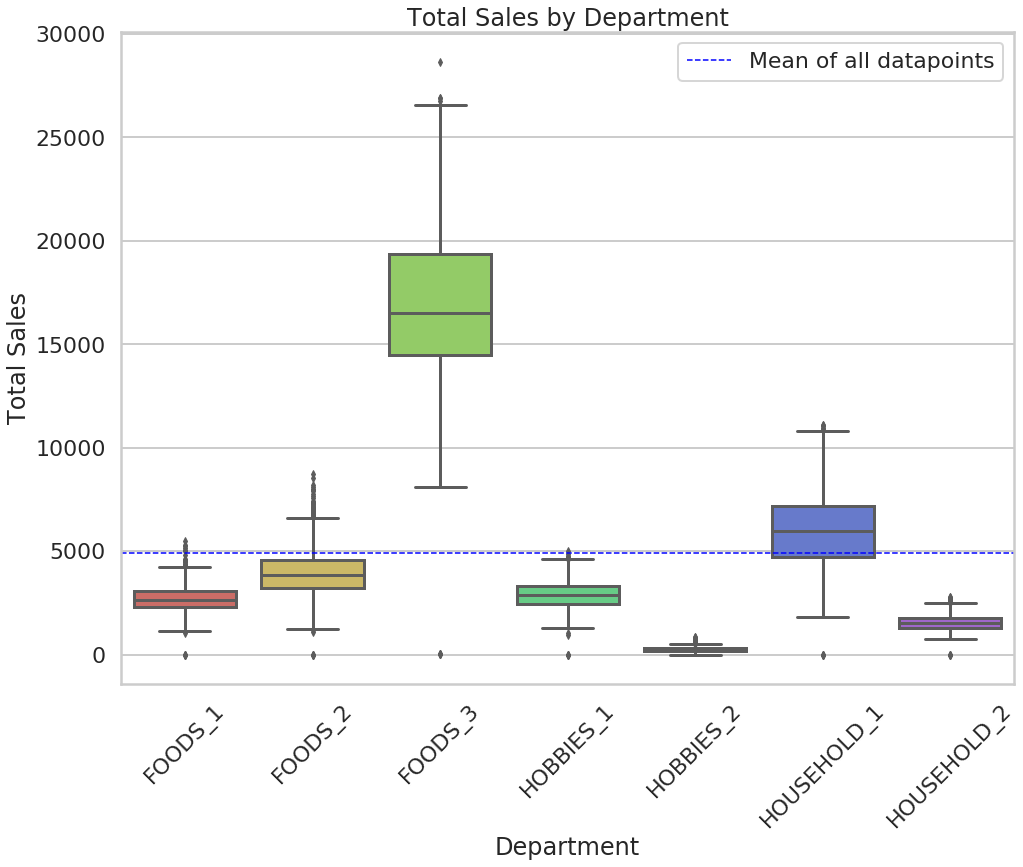

In [25]:
disp_boxplot(data = dept_sum, title = 'Total Sales by Department',xlabel = "Department", ylabel = "Total Sales")

In [26]:
# Foods_3 category and household_1 make the most total sales

store_id     CA_1  CA_2  CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2  WI_3
dept_id                                                                
FOODS_1       216   216   216   216   216   216   216   216   216   216
FOODS_2       398   398   398   398   398   398   398   398   398   398
FOODS_3       823   823   823   823   823   823   823   823   823   823
HOBBIES_1     416   416   416   416   416   416   416   416   416   416
HOBBIES_2     149   149   149   149   149   149   149   149   149   149
HOUSEHOLD_1   532   532   532   532   532   532   532   532   532   532
HOUSEHOLD_2   515   515   515   515   515   515   515   515   515   515


[Text(0.5, 1, 'Number of items in each category per store - Uniform')]

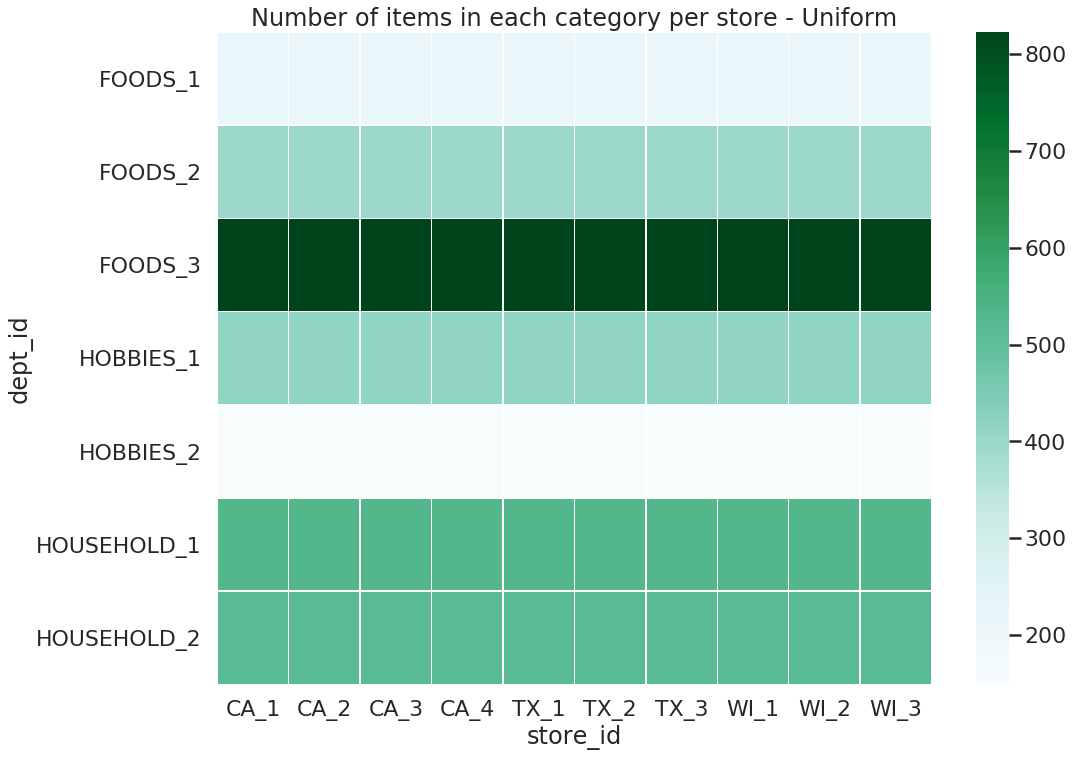

In [27]:
# all the stores have the same kind of items
dept_storeloc_cross = pd.crosstab(stv['dept_id'], stv['store_id'])
print(dept_storeloc_cross)
ax = sns.heatmap(dept_storeloc_cross,
                linewidths = 0.4,
                cmap="BuGn")
ax.set(title = 'Number of items in each category per store - Uniform')

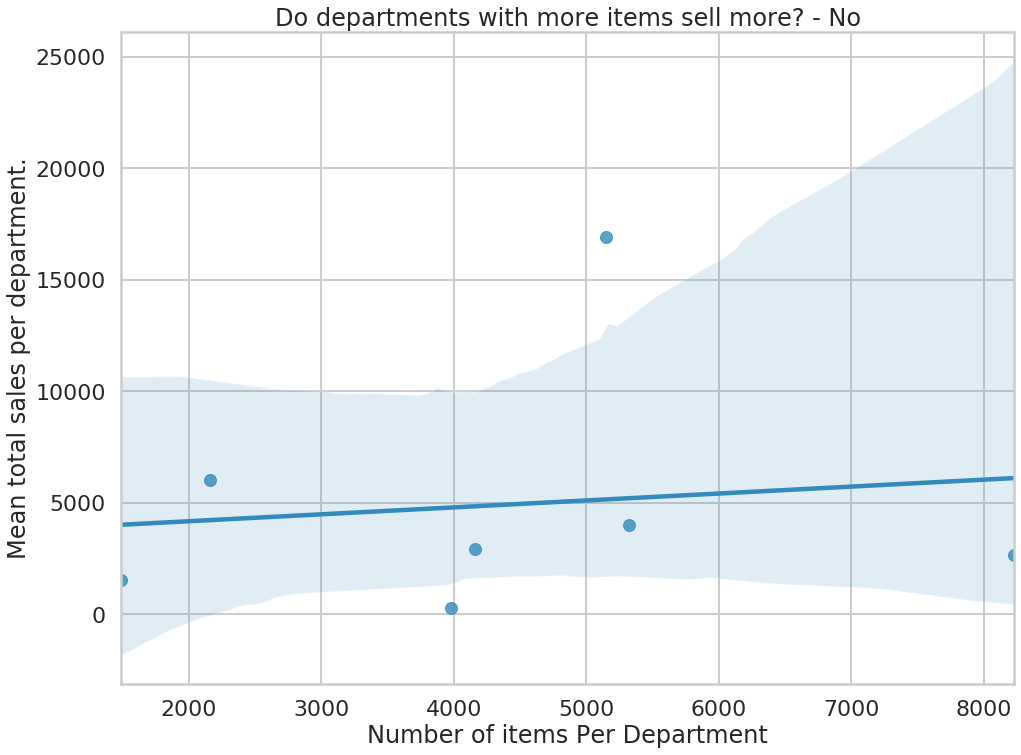

In [28]:
n_items_dept = stv['dept_id'].value_counts()
mean_of_total_sales_per_dept = dept_sum.mean(axis = 0)
ax = sns.regplot(n_items_dept, mean_of_total_sales_per_dept)
ax.set(title = 'Do departments with more items sell more? - No',
      xlabel = 'Number of items Per Department',
      ylabel = 'Mean total sales per department.')
plt.show()

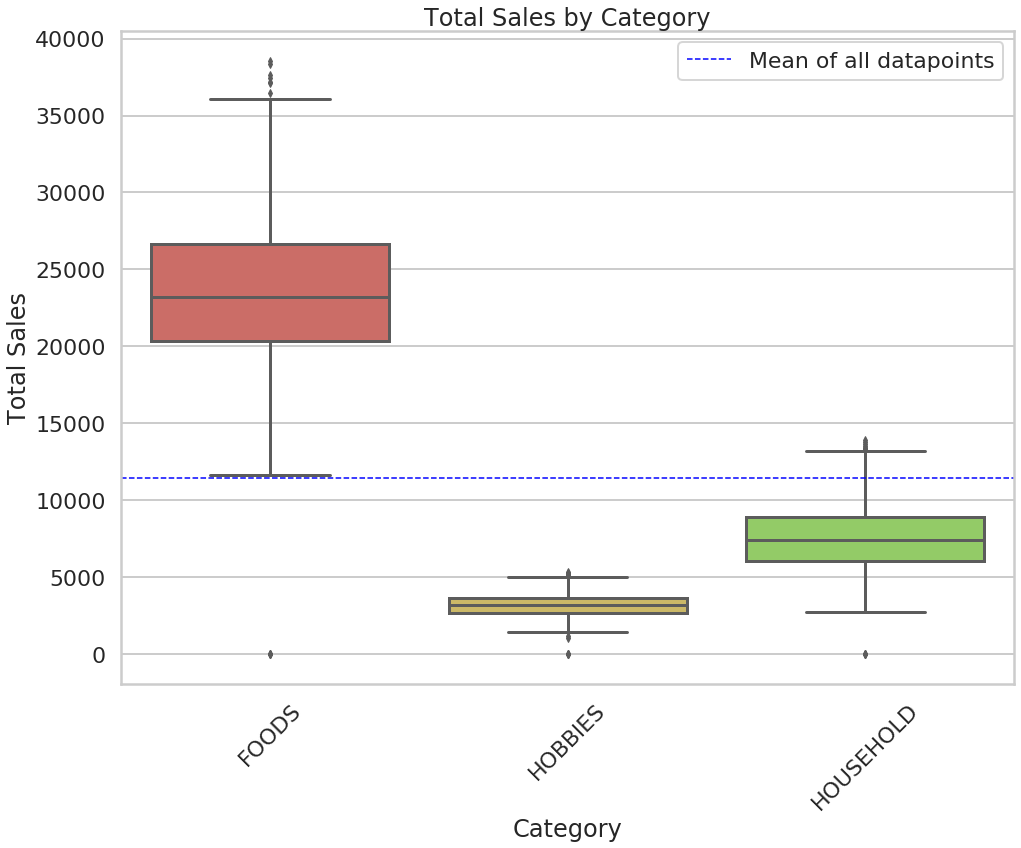

In [29]:
cat_sum = stv.groupby(['cat_id']).sum().T.reset_index(drop = True)
disp_boxplot(data = cat_sum, title = 'Total Sales by Category',
            xlabel = "Category", ylabel = "Total Sales")

In [30]:
# food has the highest sale

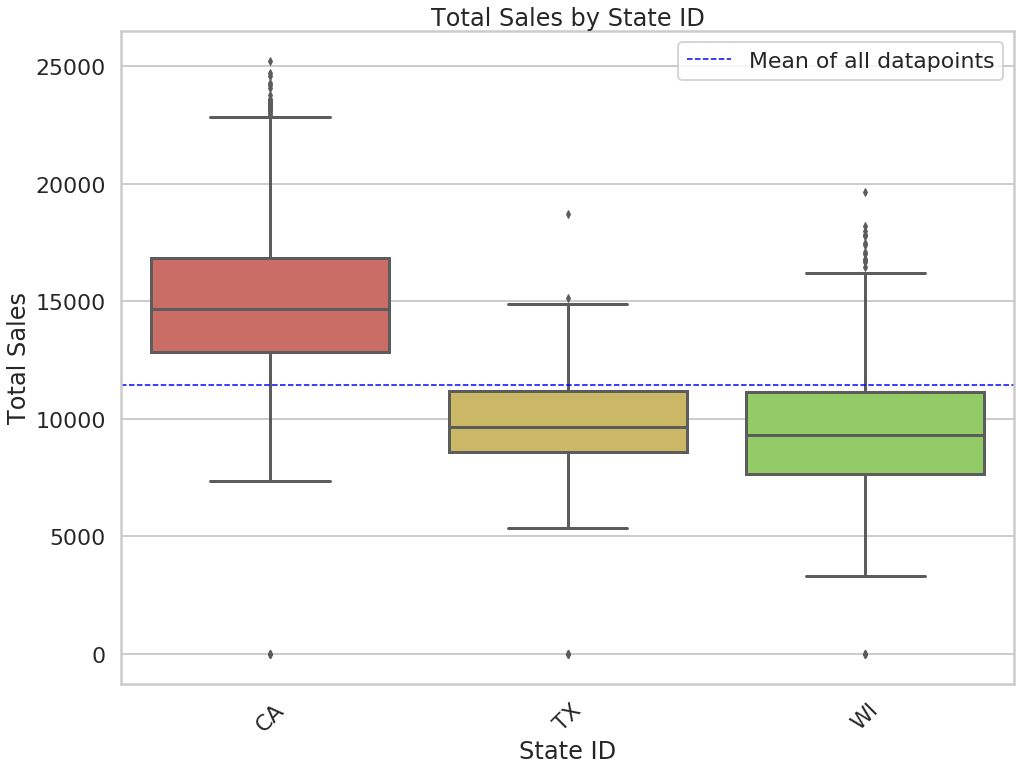

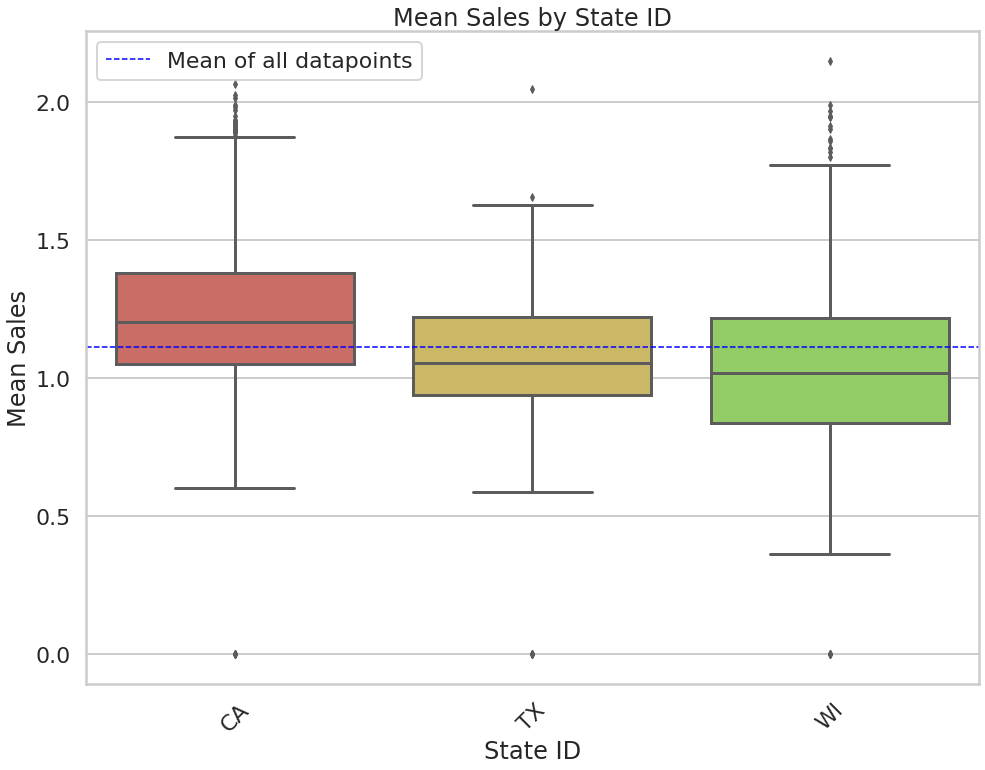

In [31]:
state_sum = stv.groupby(['state_id']).sum().T.reset_index(drop = True)
state_mean = stv.groupby(['state_id']).mean().T.reset_index(drop = True)

disp_boxplot(data = state_sum, title = 'Total Sales by State ID',
            xlabel = "State ID", ylabel = "Total Sales")

disp_boxplot(data = state_mean, title = 'Mean Sales by State ID',
            xlabel = "State ID", ylabel = "Mean Sales")

In [32]:
# Since the mean sales are not significantly higher in CA, this may show that the total sales 
# being higher in CA are simply due to there being 4 stores in the dataset instead of 3 like with TX and WI.

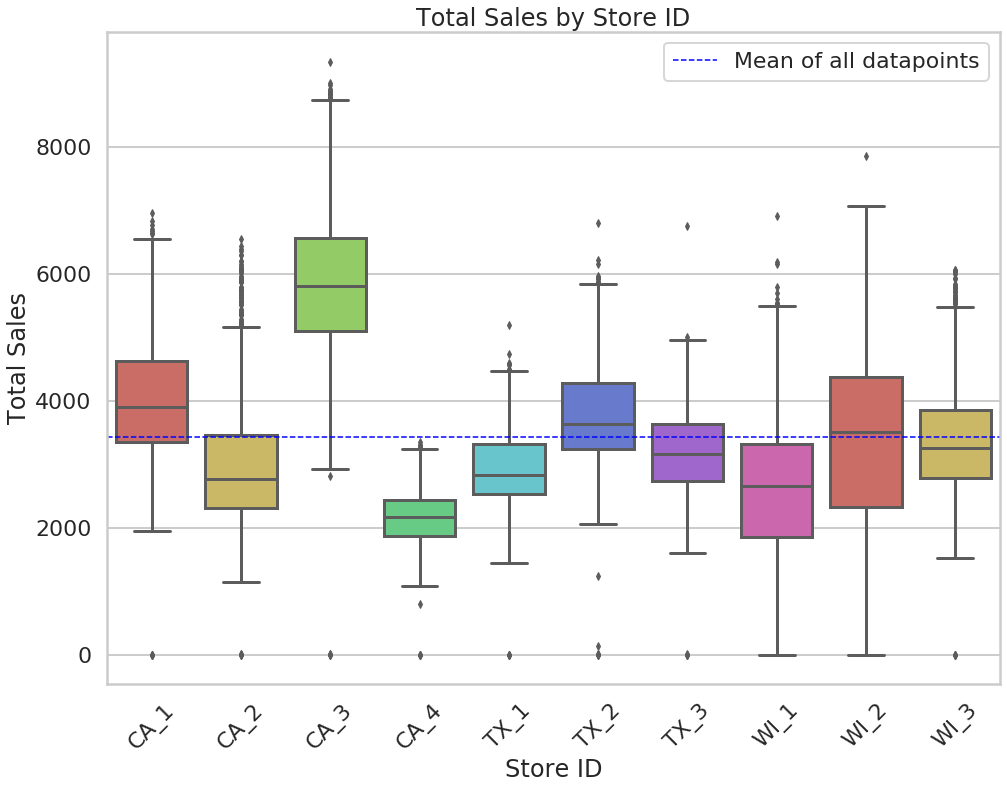

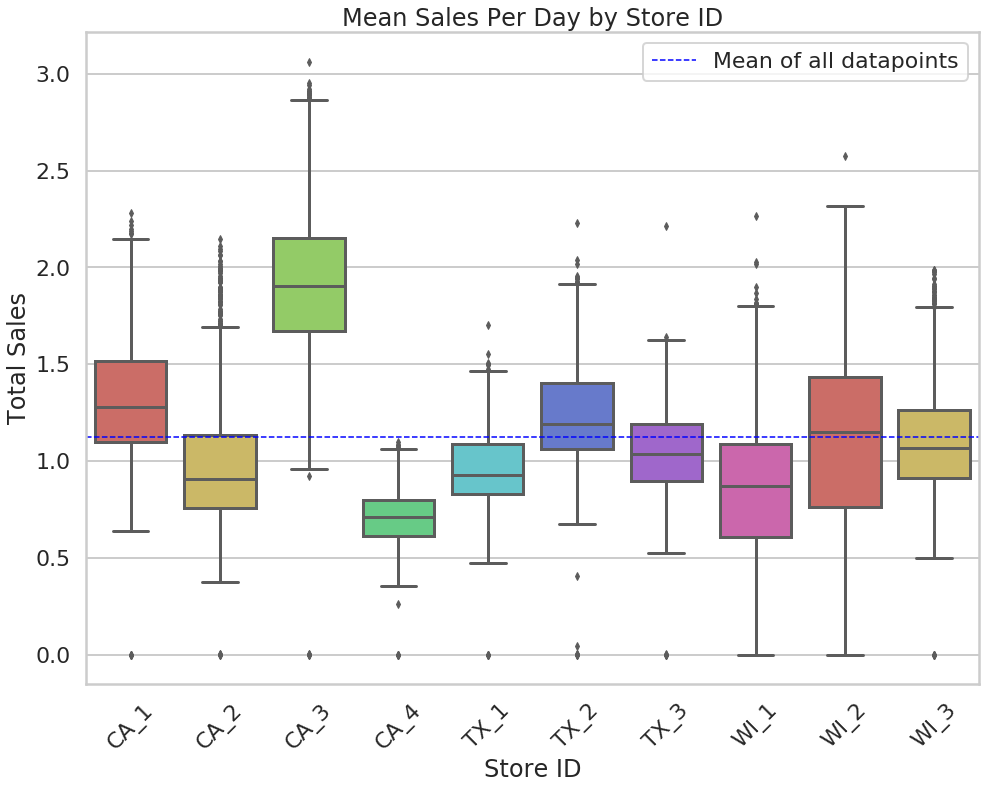

In [33]:
#sales differ by store
store_sum = stv.groupby(['store_id']).sum().T.reset_index(drop = True)
store_mean = stv.groupby(['store_id']).mean().T.reset_index(drop = True) 

disp_boxplot(data = store_sum, title = 'Total Sales by Store ID',
            xlabel = "Store ID", ylabel = "Total Sales")


disp_boxplot(data = store_mean, title = 'Mean Sales Per Day by Store ID',
            xlabel = "Store ID", ylabel = "Total Sales")

In [34]:
#While CA_3 made the most sales, CA_2 was similar to other stores and CA_4 was fairly low. 
#Even though CA does have more overall mean sales, this may be because CA_3 is significantlyhigher than all the others.

In [35]:
#Lets take a random item that sell a lot and see how it's sales look across the training data.
#FOODS_3_090_CA_3_validation sells a lot
#Note there are days where it appears the item is unavailable and sales flatline

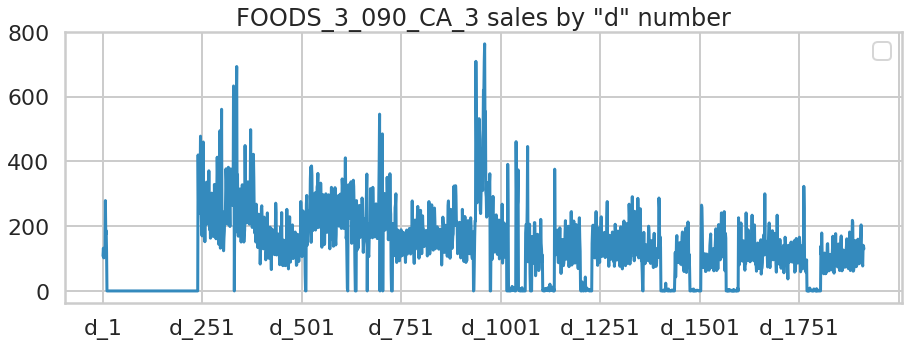

In [36]:
d_cols = [c for c in stv.columns if 'd_' in c] # sales data columns

stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'] \
    .set_index('id')[d_cols] \
    .T \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 sales by "d" number',
          color=next(color_cycle))
plt.legend('')
plt.show()

In [37]:
#We are given a calendar with additional information about past and future dates.
#The calendar data can be merged with our days data
#From this we can find weekly and annual trends

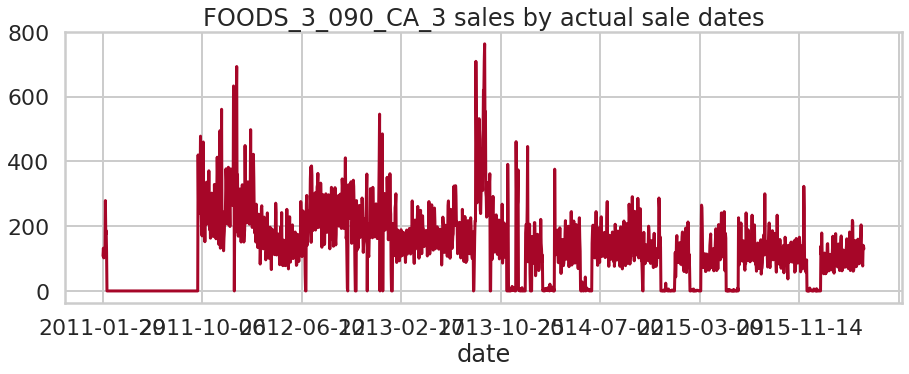

In [38]:
example = stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].T
example = example.rename(columns={8412:'FOODS_3_090_CA_3'}) # Name it correctly
example = example.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example = example.merge(cal, how='left')
example.set_index('date')['FOODS_3_090_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='FOODS_3_090_CA_3 sales by actual sale dates')
plt.show()

# Select more top selling examples
example2 = stv.loc[stv['id'] == 'HOBBIES_1_234_CA_3_validation'][d_cols].T
example2 = example2.rename(columns={6324:'HOBBIES_1_234_CA_3'}) # Name it correctly
example2 = example2.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example2 = example2.merge(cal, how='left')

example3 = stv.loc[stv['id'] == 'HOUSEHOLD_1_118_CA_3_validation'][d_cols].T
example3 = example3.rename(columns={6776:'HOUSEHOLD_1_118_CA_3'}) # Name it correctly
example3 = example3.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example3 = example3.merge(cal, how='left')

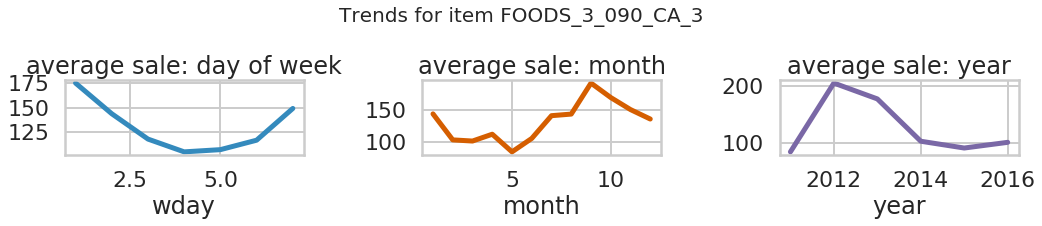

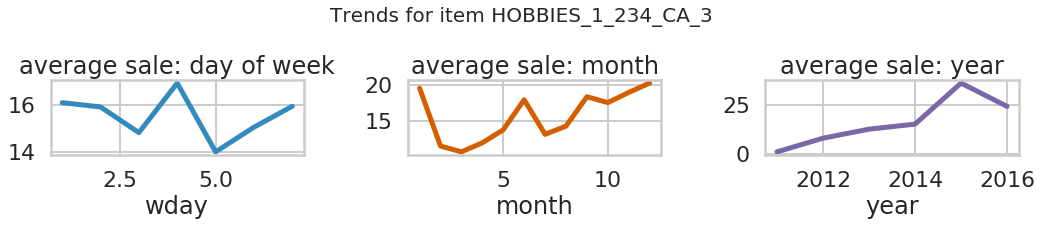

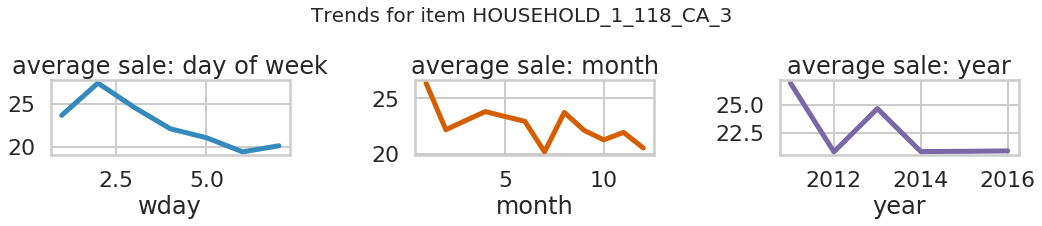

In [39]:
examples = ['FOODS_3_090_CA_3','HOBBIES_1_234_CA_3','HOUSEHOLD_1_118_CA_3']
example_df = [example, example2, example3]
for i in [0, 1, 2]:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    example_df[i].groupby('wday').mean()[examples[i]] \
        .plot(kind='line',
              title='average sale: day of week',
              lw=5,
              color=color_pal[0],
              ax=ax1)
    example_df[i].groupby('month').mean()[examples[i]] \
        .plot(kind='line',
              title='average sale: month',
              lw=5,
              color=color_pal[4],

              ax=ax2)
    example_df[i].groupby('year').mean()[examples[i]] \
        .plot(kind='line',
              lw=5,
              title='average sale: year',
              color=color_pal[2],

              ax=ax3)
    fig.suptitle('Trends for item %s'% (examples[i]),
                 size=20,
                 y=1.1)
    plt.tight_layout()
    plt.show()

In [40]:
# not the same trend

In [41]:
# more sample
twenty_examples = stv.sample(20, random_state=529) \
        .set_index('id')[d_cols] \
    .T \
    .merge(cal.set_index('d')['date'].to_frame(),
           left_index=True,
           right_index=True) \
    .set_index('date')

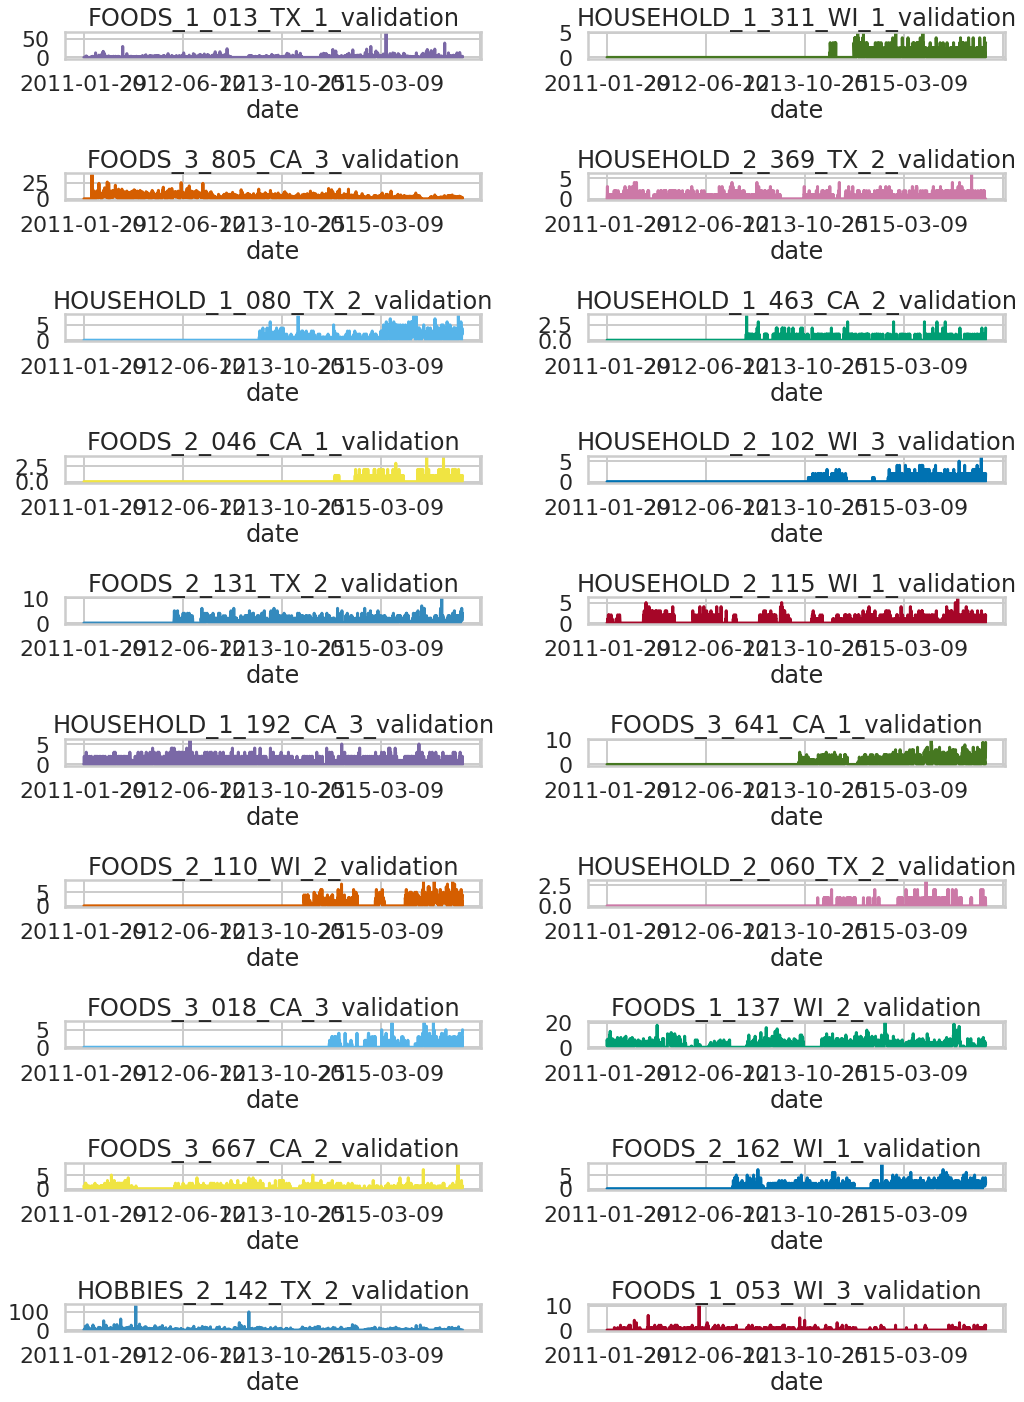

In [42]:
fig, axs = plt.subplots(10, 2, figsize=(15, 20))
axs = axs.flatten()
ax_idx = 0
for item in twenty_examples.columns:
    twenty_examples[item].plot(title=item,
                              color=next(color_cycle),
                              ax=axs[ax_idx])
    ax_idx += 1
plt.tight_layout()
plt.show()

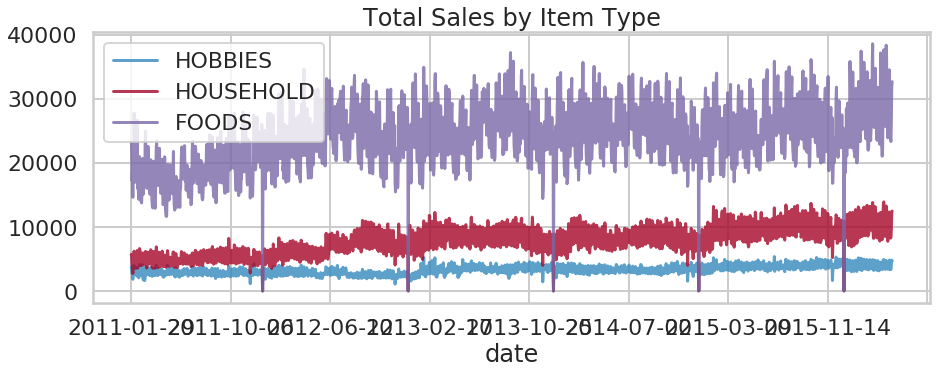

In [43]:
past_sales = stv.set_index('id')[d_cols] \
    .T \
    .merge(cal.set_index('d')['date'].to_frame(),
           left_index=True,
           right_index=True) \
    .set_index('date')


for i in stv['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col] \
        .sum(axis=1) \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Total Sales by Item Type')
plt.legend(stv['cat_id'].unique())
plt.show()

In [44]:
# food has unique peaks, household and hobiies have the same peak time

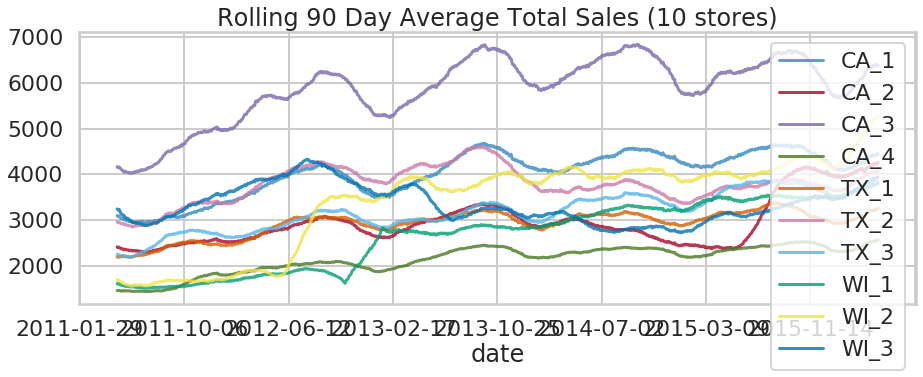

In [45]:
store_list = sellp['store_id'].unique()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(90).mean() \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Rolling 90 Day Average Total Sales (10 stores)')
plt.legend(store_list)
plt.show()

In [46]:
#Note that some stores are more steady than others.
#CA_2 seems to have a big change occur in 2015

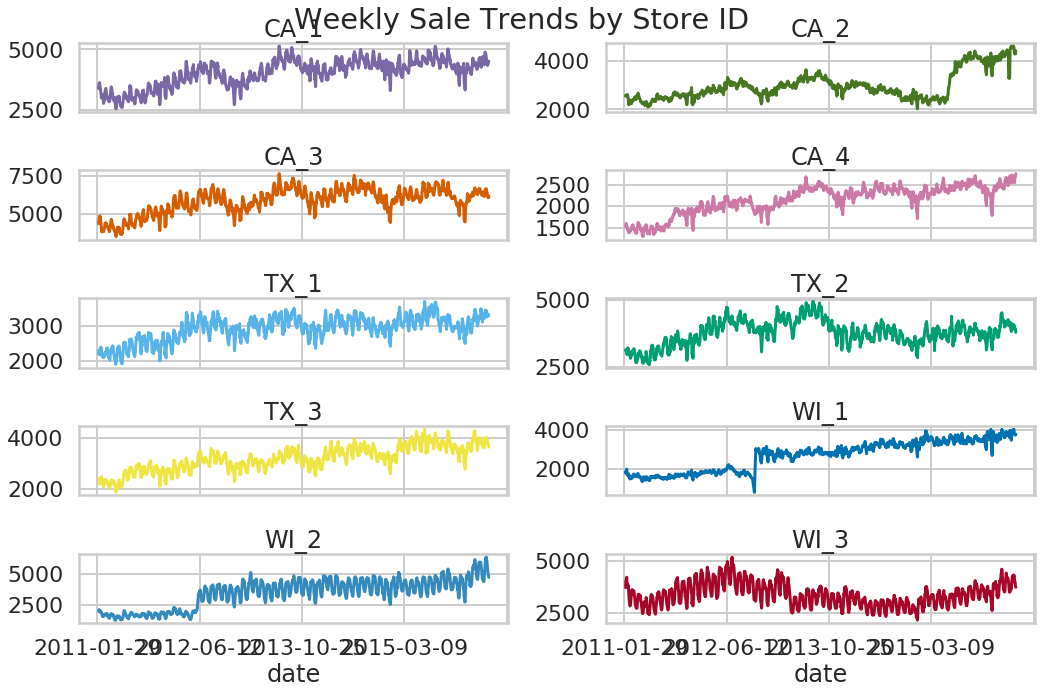

In [47]:
fig, axes = plt.subplots(5, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(7).mean() \
        .plot(alpha=1,
              ax=axes[ax_idx],
              title=s,
              lw=3,
              color=next(color_cycle))
    ax_idx += 1
plt.suptitle('Weekly Sale Trends by Store ID')
plt.tight_layout()
plt.show()

In [48]:
# plot a rolling 7 day total demand count by store. 
#Note clearly that some stores have abrupt changes in their demand, 
#it could be that the store expanded or a new competitor was built near by.

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from datetime import datetime
from dateutil.relativedelta import relativedelta


def calmap(ax, year, data):
    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders
    xticks, labels = [], []
    start = datetime(year,1,1).weekday()
    for month in range(1,13):
        first = datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)

        y0 = first.weekday()
        y1 = last.weekday()
        x0 = (int(first.strftime("%j"))+start-1)//7
        x1 = (int(last.strftime("%j"))+start-1)//7

        P = [ (x0,   y0), (x0,    7),  (x1,   7),
              (x1,   y1+1), (x1+1,  y1+1), (x1+1, 0),
              (x0+1,  0), (x0+1,  y0) ]
        xticks.append(x0 +(x1-x0+1)/2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",
                       linewidth=1, zorder=20, clip_on=False)
        ax.add_artist(poly)
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)
    ax.set_yticks(0.5 + np.arange(7))
    ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    ax.set_title("{}".format(year), weight="semibold")
    
    # Clearing first and last day from the data
    valid = datetime(year, 1, 1).weekday()
    data[:valid,0] = np.nan
    valid = datetime(year, 12, 31).weekday()
    # data[:,x1+1:] = np.nan
    data[valid+1:,x1] = np.nan

    # Showing data
    ax.imshow(data, extent=[0,53,0,7], zorder=10, vmin=-1, vmax=1,
              cmap="RdYlBu_r", origin="lower", alpha=.75)

In [50]:
print('The lowest sale date was:', past_sales.sum(axis=1).sort_values().index[0],
     'with', past_sales.sum(axis=1).sort_values().values[0], 'sales')
print('The highest sale date was:', past_sales.sum(axis=1).sort_values(ascending=False).index[0],
     'with', past_sales.sum(axis=1).sort_values(ascending=False).values[0], 'sales')

The lowest sale date was: 2012-12-25 with 11 sales
The highest sale date was: 2016-03-06 with 57218 sales


In [51]:
#walmarts are closed on Chirstmas day. 
#The highest demand day of all the data was on Sunday March 6th, 2016

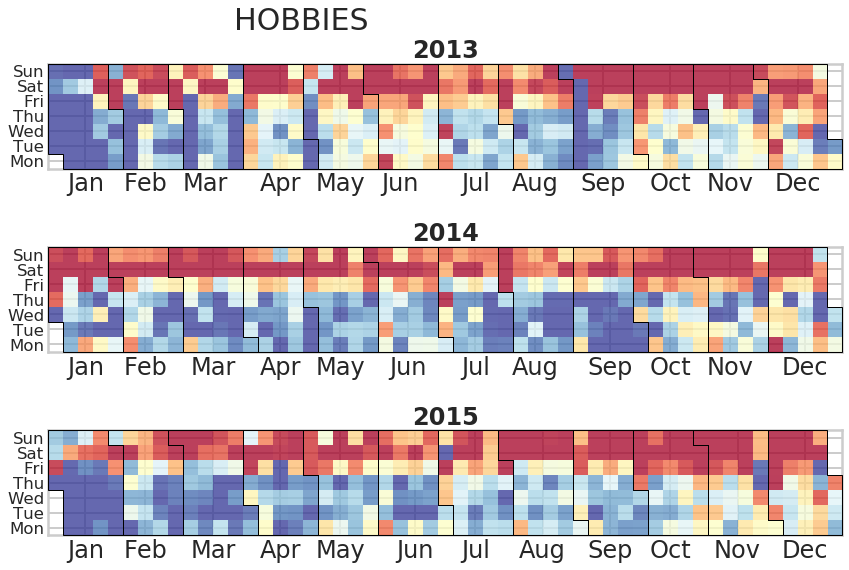

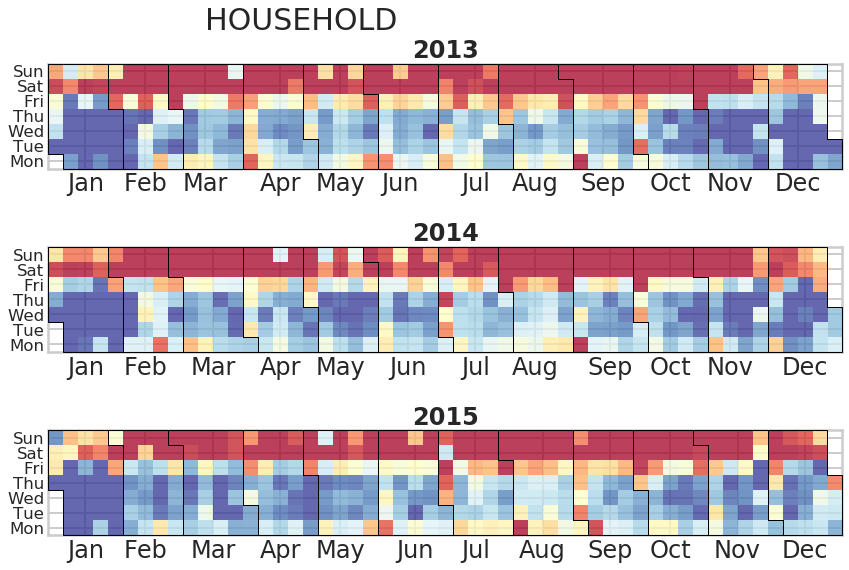

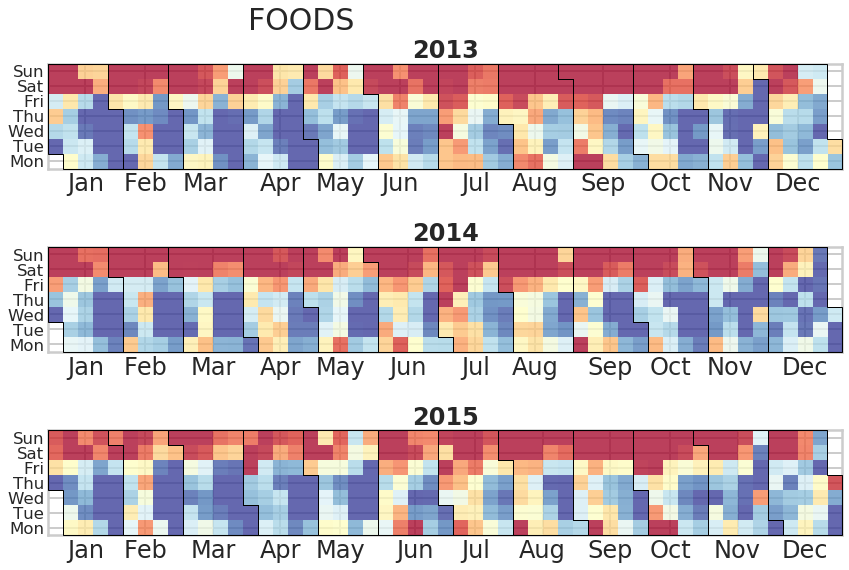

In [52]:
from sklearn.preprocessing import StandardScaler
sscale = StandardScaler()
past_sales.index = pd.to_datetime(past_sales.index)
for i in stv['cat_id'].unique():
    fig, axes = plt.subplots(3, 1, figsize=(20, 8))
    items_col = [c for c in past_sales.columns if i in c]
    sales2013 = past_sales.loc[past_sales.index.isin(pd.date_range('31-Dec-2012',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2013.values.reshape(-1, 1)))
    calmap(axes[0], 2013, vals.reshape(53,7).T)
    sales2014 = past_sales.loc[past_sales.index.isin(pd.date_range('30-Dec-2013',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2014.values.reshape(-1, 1)))
    calmap(axes[1], 2014, vals.reshape(53,7).T)
    sales2015 = past_sales.loc[past_sales.index.isin(pd.date_range('29-Dec-2014',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2015.values.reshape(-1, 1)))
    calmap(axes[2], 2015, vals.reshape(53,7).T)
    plt.suptitle(i, fontsize=30, x=0.4, y=1.01)
    plt.tight_layout()
    plt.show()

In [53]:
#Food tends to have lower number of purchases as the month goes on. 
#Could this be because people get their paychecks early in the month?
#Household and Hobby items sell much less in January - after the Holiday season is over.
#Cleary weekends are more popular shopping days regardless of the item category.

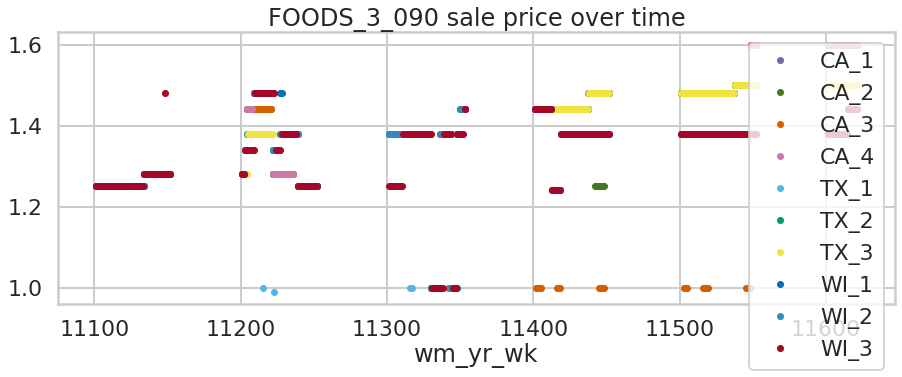

In [54]:
fig, ax = plt.subplots(figsize=(15, 5))
stores = []
for store, d in sellp.query('item_id == "FOODS_3_090"').groupby('store_id'):
    d.plot(x='wm_yr_wk',
          y='sell_price',
          style='.',
          color=next(color_cycle),
          figsize=(15, 5),
          title='FOODS_3_090 sale price over time',
         ax=ax,
          legend=store)
    stores.append(store)
    plt.legend()
plt.legend(stores)
plt.show()

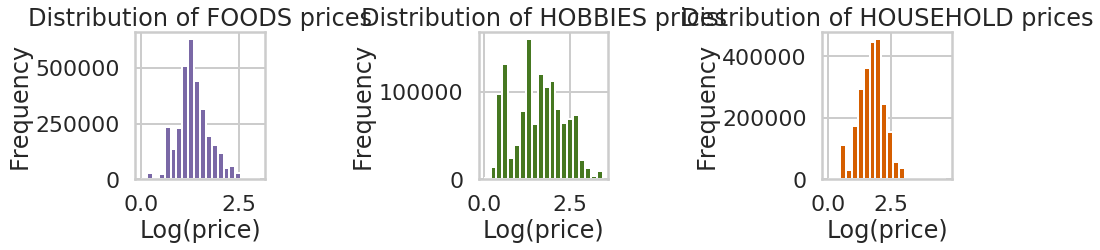

In [55]:
sellp['Category'] = sellp['item_id'].str.split('_', expand=True)[0]
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
i = 0
for cat, d in sellp.groupby('Category'):
    ax = d['sell_price'].apply(np.log1p) \
        .plot(kind='hist',
                         bins=20,
                         title=f'Distribution of {cat} prices',
                         ax=axs[i],
                                         color=next(color_cycle))
    ax.set_xlabel('Log(price)')
    i += 1
plt.tight_layout()

In [56]:
#It looks to me like the price of this item is growing.
#Different stores have different selling prices.